In [1]:
#import necessary functions, libraries and modules
# note that decision_tree_functions and helper_functions functions are in the respective .py files
import pandas as pd 
import numpy as np
import collections
import random
from pprint import pprint
import seaborn as sns
from decision_tree_functions import decision_tree_algorithm, make_predictions, calculate_accuracy
from helper_functions import generate_data, create_plot, train_test_split


In [2]:
# Open secondary_data without delimiter
mushroom_DT = mushroom_DT = pd.read_csv("/Users/Morgan/Documents/316/MushroomDataset/secondary_data.csv",sep=';',na_values='?')

In [3]:
#Drop numerical columns
mushroom_DT = mushroom_DT.drop(labels = ['cap-diameter', 'stem-height', 'stem-width'], axis=1) 
mushroom_DT.head()

,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,x,g,o,f,e,NaN,w,s,y,w,u,w,t,g,NaN,d,w
1,p,x,g,o,f,e,NaN,w,s,y,w,u,w,t,g,NaN,d,u
2,p,x,g,o,f,e,NaN,w,s,y,w,u,w,t,g,NaN,d,w
3,p,f,h,e,f,e,NaN,w,s,y,w,u,w,t,p,NaN,d,w
4,p,x,h,o,f,e,NaN,w,s,y,w,u,w,t,p,NaN,d,w


In [4]:
#check for null value
mushroom_DT.isnull().sum()

class                       0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [5]:
#replace Null Value with f
mushroom_DT = mushroom_DT [mushroom_DT.isnull().any(axis=1)]
mushroom_DT = mushroom_DT.replace(np.nan, 'f', regex=True)

In [6]:
#check for null value again
mushroom_DT.isnull().sum()

class                   0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

In [7]:
#Function to spilt dataset into training set and test set
def train_test_split(dt, test_size):
    if isinstance(test_size, float):
     test_size = round(test_size * len(dt))
    
    indices = dt.index.tolist()
    test_indices = random.sample(population = indices, k = test_size)

    test_df = dt.loc[test_indices]
    train_df = dt.drop(test_indices)


    return train_df, test_df

In [8]:
#Spilt dataset into training set and test set 0.6 to 0.4
train_df,test_df = train_test_split(mushroom_DT, test_size = 0.4)

In [9]:
#check length of training and testing set
print(len(train_df),len(test_df))
print(type(train_df),type(test_df))

36641 24428
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [10]:
data=train_df.values
data[:5]

array([['p', 'f', 'h', 'e', 'f', 'e', 'f', 'w', 's', 'y', 'w', 'u', 'w',
        't', 'p', 'f', 'd', 'w'],
       ['p', 'x', 'g', 'o', 'f', 'e', 'f', 'w', 's', 'y', 'w', 'u', 'w',
        't', 'p', 'f', 'd', 'u'],
       ['p', 'f', 'h', 'o', 'f', 'e', 'f', 'w', 's', 'y', 'w', 'u', 'w',
        't', 'g', 'f', 'd', 'w'],
       ['p', 'x', 'h', 'o', 'f', 'e', 'f', 'w', 's', 'y', 'w', 'u', 'w',
        't', 'g', 'f', 'd', 'u'],
       ['p', 'f', 'h', 'e', 'f', 'e', 'f', 'w', 's', 'y', 'w', 'u', 'w',
        't', 'p', 'f', 'd', 'a']], dtype=object)

In [11]:
#function to check if the subtree contains only one label
def check_label(tree):
    labels=tree[:,0]
    unique_labels=np.unique(labels)
    
    if len(unique_labels)==1:
        return True
    else:
        return False

In [12]:
#function to classify data label at the end of stopping criteria
def classify(tree):
    labels=tree[:,0]
    unique_labels,count_unique=np.unique(labels,return_counts=True)
    #print(unique_labels)
    
    max_value=count_unique.argmax()
    
    return unique_labels[max_value]

In [13]:
#function to differentiate the features as continuous or categorical
def type_features(data):
    
    feature_types = []
    threshold = 15
    for feature in data.columns:
        if feature != "class":
            unique_values = data[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= threshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [14]:
#function to find all the possible split points in the tree
def find_potential_splits(tree):
    #dictionary to store a list of possible splits for every column in key value pair
    potential_split_values={}
    no_columns=(tree.shape)[1]
    for column in range(0,no_columns):
        #finding the possible splits for every column
        column_data=tree[:,column]
        unique_values=np.unique(column_data)
        feature = unique_values.all()
#Appending calculated split value to the list pointing to particular column
        if feature == "continuous":
            potential_split_values[column] = []
            for index in range(len(unique_values)):
                #calculating the midpoint between every 2 points
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value) / 2

                    potential_split_values[column].append(potential_split)
        
        # feature is categorical
        #more than one label must be present 
        elif len(unique_values) > 1:
            potential_split_values[column] = unique_values
      
            
    return potential_split_values
                           

In [15]:
# test find_potential_splits function
find_potential_splits(data)

{0: array(['e', 'p'], dtype=object),
 1: array(['b', 'c', 'f', 'o', 'p', 's', 'x'], dtype=object),
 2: array(['d', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 's', 't', 'w', 'y'],
       dtype=object),
 3: array(['b', 'e', 'g', 'k', 'l', 'n', 'o', 'p', 'r', 'u', 'w', 'y'],
       dtype=object),
 4: array(['f', 't'], dtype=object),
 5: array(['a', 'd', 'e', 'f', 'p', 's', 'x'], dtype=object),
 6: array(['c', 'd', 'f'], dtype=object),
 7: array(['b', 'e', 'f', 'g', 'k', 'n', 'o', 'p', 'r', 'u', 'w', 'y'],
       dtype=object),
 8: array(['b', 'c', 'f', 'r', 's'], dtype=object),
 9: array(['f', 'g', 'h', 'i', 'k', 's', 't', 'y'], dtype=object),
 10: array(['b', 'e', 'f', 'g', 'k', 'l', 'n', 'o', 'p', 'r', 'u', 'w', 'y'],
       dtype=object),
 11: array(['f', 'u'], dtype=object),
 12: array(['e', 'f', 'k', 'n', 'u', 'w', 'y'], dtype=object),
 13: array(['f', 't'], dtype=object),
 14: array(['e', 'f', 'g', 'l', 'm', 'p', 'r', 'z'], dtype=object),
 15: array(['f', 'g', 'k', 'n', 'p', 'r', 'u', 'w'],

In [16]:
#function to split the tree into left and right subtree based on condition
def split(tree,column,value):
    column_data=tree[:,column]
    
    feature = column_data[column - 3]
    if feature == "continuous":
        #comparison for continuous data
        left=tree[column_data<=value]
        right=tree[column_data>value]
    else:
        #comparison for categorical data
        left=tree[column_data==value]
        right=tree[column_data!=value]
    return left,right

In [17]:
#Test split function
column = 1
value = 0.8
data_below,data_above = split(data,column,value)
data_above 

array([['p', 'f', 'h', ..., 'f', 'd', 'w'],
       ['p', 'x', 'g', ..., 'f', 'd', 'u'],
       ['p', 'f', 'h', ..., 'f', 'd', 'w'],
       ...,
       ['p', 's', 's', ..., 'f', 'd', 'a'],
       ['p', 'f', 's', ..., 'f', 'd', 'a'],
       ['p', 'f', 's', ..., 'f', 'd', 'u']], dtype=object)

In [18]:
"""
def calculate_entropy(tree, flag='e'):
    
    labels=tree[:,0]    
    unique_labels,count_unique=np.unique(labels,return_counts=True)
    d=dict(zip(unique_labels,count_unique))
    gini=0.0
    #print(d)
    if flag=='g':
        total=count_unique.sum()
        for key in d.keys():
            gini=gini+((d[key]/total)**2)
        gini=1-gini
        return gini
    if flag=='e':
        probability=count_unique/count_unique.sum()
        entropy=sum(probability*-np.log2(probability))
     
    return entropy
"""

"\ndef calculate_entropy(tree, flag='e'):\n    \n    labels=tree[:,0]    \n    unique_labels,count_unique=np.unique(labels,return_counts=True)\n    d=dict(zip(unique_labels,count_unique))\n    gini=0.0\n    #print(d)\n    if flag=='g':\n        total=count_unique.sum()\n        for key in d.keys():\n            gini=gini+((d[key]/total)**2)\n        gini=1-gini\n        return gini\n    if flag=='e':\n        probability=count_unique/count_unique.sum()\n        entropy=sum(probability*-np.log2(probability))\n     \n    return entropy\n"

In [19]:
#function to calculate entropy
def calculate_entropy(tree):
    
    label_column = tree[:, 0]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [20]:
# Test entropy function
calculate_entropy(data)

0.9914765665162584

In [21]:
"""
#function to calculate overall gini impurity or entropy impurity depending on flag value
def calculate_overall_entropy(data_below,data_above,flag='e'):
    n=len(data_below)+len(data_above)
    p_left=len(data_below)/n
    p_right=len(data_above)/n

    
    if flag=='g':
        lunique_labels,lcount_unique=np.unique(data_below,return_counts=True)
        runique_labels,rcount_unique=np.unique(data_above,return_counts=True)
        left_dict=dict(zip(lunique_labels, lcount_unique))
        lpn= left_dict['p']
        right_dict=dict(zip(runique_labels, rcount_unique))
        rpn=right_dict['p']
        overall_imp=((lpn/n)*calculate_entropy(data_below,flag))+((rpn/n)*calculate_entropy(data_above,flag))
    if flag=='e':
        overall_imp=(p_left*calculate_entropy(data_below,flag)+p_right*calculate_entropy(data_above,flag))
    return overall_imp
    
"""

"\n#function to calculate overall gini impurity or entropy impurity depending on flag value\ndef calculate_overall_entropy(data_below,data_above,flag='e'):\n    n=len(data_below)+len(data_above)\n    p_left=len(data_below)/n\n    p_right=len(data_above)/n\n\n    \n    if flag=='g':\n        lunique_labels,lcount_unique=np.unique(data_below,return_counts=True)\n        runique_labels,rcount_unique=np.unique(data_above,return_counts=True)\n        left_dict=dict(zip(lunique_labels, lcount_unique))\n        lpn= left_dict['p']\n        right_dict=dict(zip(runique_labels, rcount_unique))\n        rpn=right_dict['p']\n        overall_imp=((lpn/n)*calculate_entropy(data_below,flag))+((rpn/n)*calculate_entropy(data_above,flag))\n    if flag=='e':\n        overall_imp=(p_left*calculate_entropy(data_below,flag)+p_right*calculate_entropy(data_above,flag))\n    return overall_imp\n    \n"

In [22]:
# function to calculate overall entropy
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [23]:
# test function  calculate_overall_entropy
calculate_overall_entropy(data_below,data_above)

0.9914765665162584

In [24]:
"""
def determine_best_split(tree, potential_splits):
    
   overall_imp=999
   for column in potential_splits:
    for value in potential_splits[column]:
        if not isinstance(value,str):
            continue
        left,right=split(tree,column,value)
        current_impurity=calculate_overall_entropy(left,right)

        if current_impurity<overall_imp:
            overall_imp=current_impurity
            best_column=column
            best_value=value
    return best_column,best_value
"""

'\ndef determine_best_split(tree, potential_splits):\n    \n   overall_imp=999\n   for column in potential_splits:\n    for value in potential_splits[column]:\n        if not isinstance(value,str):\n            continue\n        left,right=split(tree,column,value)\n        current_impurity=calculate_overall_entropy(left,right)\n\n        if current_impurity<overall_imp:\n            overall_imp=current_impurity\n            best_column=column\n            best_value=value\n    return best_column,best_value\n'

In [25]:
#function to determine best split in dataset for decision tree
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split(data, column_index, value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [26]:
#Test determine_best_split function
potential_splits = find_potential_splits(data)
determine_best_split(data,potential_splits)

(0, 'p')

In [27]:
#function to seperate the features as continuous or categorical
def type_features(data):
    
    feature_types = []
    threshold = 15
    for feature in data.columns:
        if feature != "label":
            unique_values = data[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= threshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [28]:
# Main Decision_tree function
def decision_tree(data,counter=0,min_samples=2,max_depth=5):
    #for first case with root node
    if counter == 0:
        global column_headings,features_types
        column_headings=data.columns
        features_types=type_features(data)
        data = data.values
    else:
        data = data
    #stopping criteria for recursion
    if (check_label(data)):# or (len(data)<=min_samples) or (counter==max_depth):
        classification=classify(data)
        
        return classification
    
    else:
        #recursion starts and counter value increased
        counter=counter+1
        #find all potential split values in the data
        potential_splits= find_potential_splits(data)
        #find the best split column and its respective value
        best_column,best_value= determine_best_split(data,potential_splits)
        #split the data according to the parameters received above
        left,right=split(data,best_column,best_value)
        #find the feature used to split data
        feature=column_headings[best_column]
        #find the type of feature
        feature_type = features_types[best_column-1]
        #representation of question in the tree
        if feature_type == "continuous":
            question="{} <= {}".format(feature,best_value)
        else:
            question="{} == {}".format(feature,best_value)
        #creating the subtrees
        subtree = {question: []}
        
        yes=decision_tree(left,counter,min_samples)
        no=decision_tree(right,counter,min_samples)
        #if both subtrees result the same result no need to progress
        if yes==no:
            subtree=yes
        else:
            #appending appropriate values
            subtree[question].append(yes)
            subtree[question].append(no)
        
        return subtree

In [29]:
#Test Decision tree function
tree = decision_tree(train_df, max_depth=3)
pprint(tree)

{'class == p': ['p', 'e']}


In [30]:
print(features_types)

['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical']


In [31]:
#testing the trained decision tree with single sample
example = test_df.iloc[0]
example

class                   e
cap-shape               p
cap-surface             d
cap-color               e
does-bruise-or-bleed    f
gill-attachment         p
gill-spacing            f
gill-color              w
stem-root               s
stem-surface            y
stem-color              w
veil-type               f
veil-color              f
has-ring                f
ring-type               f
spore-print-color       f
habitat                 d
season                  u
Name: 51860, dtype: object

In [32]:
#function to classify the tree for single sample
def classify_example(example,tree):
    question=list(tree.keys())[0]
    feature,operator,value=question.split()
    if operator=="<=":
        if example[feature]<=float(value):
            answer=tree[question][0]
        else:
            answer=tree[question][1]
    else:
        if str(example[feature])==value:
            answer=tree[question][0]
        else:
            answer=tree[question][1]
          
    
    if not isinstance(answer,dict):
        return answer
    else:
        rem_tree=answer
        return classify_example(example,rem_tree)

In [33]:
classify_example(example, tree)

'e'

In [34]:
#rename class to label in training set
train_df["label"] = train_df["class"]

In [35]:
#function to confusion_matrix of the tree
def confusion_matrix(data,tree):
    data["classification"]=data.apply(classify_example,axis=1,args=(tree,))
    data["classification_Is_correct"]=data.classification==data.label
    
    Y_actual_values = pd.Series(data.label, name='Actual')
    y_predct_values = pd.Series(data.classification, name='Predicted')
    df_confusion = pd.crosstab(Y_actual_values, y_predct_values)
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    print("Confusion Matrix",end='\n\n')
    print(df_confusion,end='\n\n')
    print("Normalised Confusion Matrix",end='\n\n')
    print(df_conf_norm,end='\n\n')    
   
    index = pd.IndexSlice
    TP=df_confusion.loc['e', index['e']]
    FP=df_confusion.loc['p', index['e']]
    TN=df_confusion.loc['p', index['p']]
    FN=df_confusion.loc['e', index['p']]
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    precision= TP/(TP+FP)
    recall=TP/(TP+FN)
    f1=2*((precision*recall)/(precision+recall))
    #accuracy=data.classification_correct.mean()
    return accuracy,f1
    

In [36]:
#displaying accuracy for train data for gini impurity
accuracy,f1 = confusion_matrix(train_df, tree)
print("Accuracy=",accuracy)
print("F1 Score=",f1)

Confusion Matrix

Predicted      e      p
Actual                 
e          16331      0
p              0  20310

Normalised Confusion Matrix

Predicted    e    p
Actual             
e          1.0  0.0
p          0.0  1.0

Accuracy= 1.0
F1 Score= 1.0


In [37]:
#printing the tree for test data with gini impurity 
tr_data, ts_data = train_test_split(train_df, test_size = 0.5)

calculate_accuracy(ts_data, tree)

pprint(tree)
print("Accuracy=",accuracy)
print("F1 Score=",f1)

{'class == p': ['p', 'e']}
Accuracy= 1.0
F1 Score= 1.0


In [38]:
mushroom_DT["label"] = mushroom_DT.season

In [39]:
#helper functions for post pruning
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [40]:
def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
        return df_train.label.value_counts().index[0]

In [41]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    if ml_task == "regression":
        # mean squared error
        return ((predictions - actual_values) **2).mean()
    else:
        # number of errors
        return sum(predictions != actual_values)

In [42]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [43]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

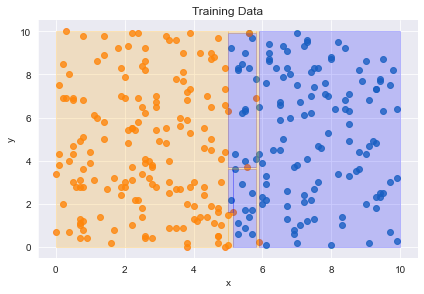

In [44]:
# np.random.seed(0)
df_train = generate_data(n=300, n_random_outliers=5)
tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=10)
create_plot(df_train, tree, title="Training Data")

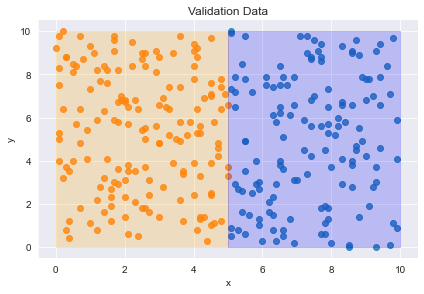

In [45]:
# np.random.seed(7)
df_val = generate_data(n=300)
tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
create_plot(df_val, tree_pruned, title="Validation Data")

In [46]:
#omparing the accuracy of the tree before and after post-pruning using different values for the "max_depth" parameter.
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}

for n in range(10, 100):
#split training by 0.6 to 0.4
#split remaining 0.4 into half
    df_train, df_test = train_test_split(mushroom_DT, test_size=0.6)
    df_train, df_val = train_test_split(df_train, test_size=0.5)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")

    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
       
df_metrics = pd.DataFrame(metrics)  
df_metrics = df_metrics.set_index("max_depth")

<AxesSubplot:xlabel='max_depth'>

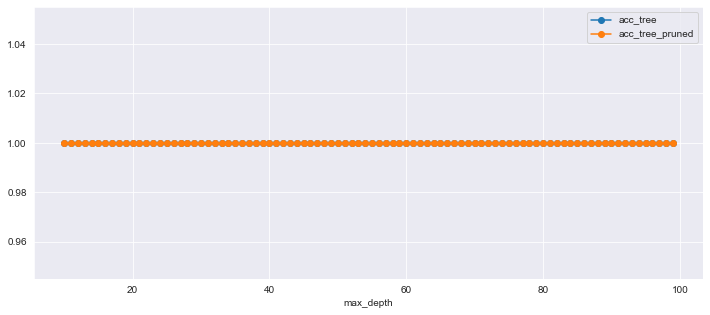

In [47]:
#plot graph
df_metrics.plot(figsize=(12, 5), marker="o")